In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pingouin as pg
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2]:
print("==== STUDENT LIFESTYLE IMPACT ON GPA ANALYSIS ====")

N = 192                   # population (as given)
E = 0.10                  # margin of error (10%)
p = 0.50                  # assumed proportion
CL = 0.90                 # confidence level (90%)
alpha = 0.10              # significance level (alpha = 10%)
Z = stats.norm.ppf(1 - alpha/2)   # Z = 1.645 for 90% CL

# Infinite-population estimate
n0 = (Z**2 * p * (1-p)) / (E**2)
# Finite-population correction
n = n0 / (1 + (n0 - 1)/N)

print("\n--- Sample Size Calculation ---")
print(f"Population size (N): {N}")
print(f"Confidence Level: {CL*100}%")
print(f"Margin of Error: {E*100}%")
print(f"Required sample size (infinite pop): {n0:.1f}")
print(f"Required sample size (adjusted for N={N}): {n:.1f}")
print(f"Minimum sample needed: {np.ceil(n)}")

==== STUDENT LIFESTYLE IMPACT ON GPA ANALYSIS ====

--- Sample Size Calculation ---
Population size (N): 192
Confidence Level: 90.0%
Margin of Error: 10.0%
Required sample size (infinite pop): 67.6
Required sample size (adjusted for N=192): 50.2
Minimum sample needed: 51.0


In [ ]:
df = pd.read_excel("DataAfter_4.xlsx")

df.columns = (
    df.columns
    .str.strip()
    .str.lower()                                    # lowercase
    .str.replace(r'[^0-9a-z_]', '_', regex=True)    # non-alnum → underscore
    .str.replace(r'__+', '_', regex=True)           # collapse multiple _
    .str.strip('_')                                 # trim leading/trailing _
)

print("\n--- Sanitized Column Names ---")
df.head()


--- Sanitized Column Names ---


,ipk,jam_belajar_uts_uas_1_4,ngatur_waktu_kuliah_tugas_belajar_1_5,mudah_memahami_materi_1_5,notes_ringkasan_kuliah_1_5,jadwal_belajar_teratur_1_5,memanfaatkan_ai_1_5,revisi_pelajaran_1_5,jumlah_organisasi_0_3,terbebani_organisasi_1_5,...,kerja_sampingan_mengganggu_1_5,sosial_media_1_4,medsos_mengganggu_1_5,waktu_tidur_1_4,waktu_tidur_cukup_1_5,aktivitas_diluar_rumah_1_5,pengaruh_lingkungan_mendukung_pembelajaran_1_5,teman2_mendukung_akademik_1_5,lingkungan_pertemanan_mempengaruhi_ipk_1_5,dosen_mempengaruhi_akademik_1_5
0,3.29,2,2,3,2,3,5,1,0,3,...,3,2,4,3,5,3,2,5,2,2
1,3.43,2,2,3,3,2,5,2,1,4,...,3,2,5,2,3,3,4,3,4,4
2,3.14,4,2,3,3,2,5,3,1,3,...,2,4,4,1,2,2,4,4,4,4
3,3.71,1,3,2,5,2,5,3,1,1,...,3,4,5,3,5,3,5,5,5,5
4,3.72,3,4,3,5,1,4,2,3,5,...,5,1,1,2,1,4,1,3,5,5


## Measurement Quality

In [4]:
print("\n==== MEASUREMENT QUALITY TESTING ====")

# Reliability Analysis (Cronbach's Alpha)
items = df.columns.drop('ipk').tolist()
alpha_score, ci = pg.cronbach_alpha(df[items], ci=0.90)
print("\n--- Reliability Analysis (Cronbach's Alpha) ---")
print(f"Cronbach's α (all lifestyle items): {alpha_score:.3f}")
print(f"90% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")

# Interpretation of reliability
if alpha_score >= 0.9:
    reliability = "Excellent"
elif alpha_score >= 0.8:
    reliability = "Good"
elif alpha_score >= 0.7:
    reliability = "Acceptable"
elif alpha_score >= 0.6:
    reliability = "Questionable"
elif alpha_score >= 0.5:
    reliability = "Poor"
else:
    reliability = "Unacceptable"
print(f"Reliability interpretation: {reliability}")


==== MEASUREMENT QUALITY TESTING ====

--- Reliability Analysis (Cronbach's Alpha) ---
Cronbach's α (all lifestyle items): 0.613
90% CI: [0.472, 0.733]
Reliability interpretation: Questionable


In [5]:
print("\n--- Cronbach's Alpha Calculation Details ---")
item_variances = df[items].var(ddof=1)
total_variance = df[items].sum(axis=1).var(ddof=1)
k = len(items)
print(f"Number of items (k): {k}")
print(f"Sum of item variances: {item_variances.sum():.3f}")
print(f"Variance of total scores: {total_variance:.3f}")
print(f"Cronbach's Alpha = (k/(k-1)) * (1 - (sum of item variances/total variance))")
print(f"                 = ({k}/{k-1}) * (1 - ({item_variances.sum():.3f}/{total_variance:.3f}))")
print(f"                 = {alpha_score:.3f}")


--- Cronbach's Alpha Calculation Details ---
Number of items (k): 20
Sum of item variances: 20.639
Variance of total scores: 49.443
Cronbach's Alpha = (k/(k-1)) * (1 - (sum of item variances/total variance))
                 = (20/19) * (1 - (20.639/49.443))
                 = 0.613


## Preliminary Analysis

In [21]:
print("\n==== PRELIMINARY ANALYSIS ====")

# a) Descriptive statistics
print("\n--- Descriptive Statistics ---")
desc_stats = df.describe().T[['mean', 'std', 'min', 'max']]
desc_stats['range'] = desc_stats['max'] - desc_stats['min']
desc_stats


==== PRELIMINARY ANALYSIS ====

--- Descriptive Statistics ---


,mean,std,min,max,range
ipk,3.503333,0.370317,2.49,3.99,1.5
jam_belajar_uts_uas_1_4,2.313725,1.009756,1.00,4.00,3.0
ngatur_waktu_kuliah_tugas_belajar_1_5,3.490196,1.046376,1.00,5.00,4.0
mudah_memahami_materi_1_5,3.372549,1.038476,1.00,5.00,4.0
notes_ringkasan_kuliah_1_5,3.529412,1.270479,1.00,5.00,4.0
jadwal_belajar_teratur_1_5,2.254902,1.293725,1.00,5.00,4.0
memanfaatkan_ai_1_5,4.411765,0.828890,2.00,5.00,3.0
revisi_pelajaran_1_5,2.529412,1.189167,1.00,5.00,4.0
jumlah_organisasi_0_3,1.156863,0.966903,0.00,3.00,3.0
terbebani_organisasi_1_5,2.843137,1.065318,1.00,5.00,4.0


In [7]:
# b) Pearson correlations & p-values vs IPK
print("\n--- Correlations with IPK ---")
corrs = []
for col in items:
    r, pval = stats.pearsonr(df['ipk'], df[col])
    corrs.append({
        'variable': col, 
        'r': r, 
        'r_squared': r**2,
        'p-value': pval, 
        'significant': pval < alpha,
        'strength': 'strong' if abs(r) > 0.5 else 'moderate' if abs(r) > 0.3 else 'weak',
        'direction': 'positive' if r > 0 else 'negative'
    })

corr_df = pd.DataFrame(corrs).sort_values('r', key=abs, ascending=False)
print(corr_df[['variable', 'r', 'r_squared', 'p-value', 'significant']].to_string(index=False))


--- Correlations with IPK ---
                                      variable         r  r_squared  p-value  significant
         ngatur_waktu_kuliah_tugas_belajar_1_5  0.378160   0.143005 0.006218         True
               dosen_mempengaruhi_akademik_1_5  0.376658   0.141871 0.006443         True
                             kerja_samping_0_1  0.348879   0.121717 0.012103         True
                    notes_ringkasan_kuliah_1_5  0.327325   0.107142 0.019047         True
    lingkungan_pertemanan_mempengaruhi_ipk_1_5  0.264646   0.070038 0.060557         True
                      terbebani_organisasi_1_5  0.223909   0.050135 0.114217        False
                       jam_belajar_uts_uas_1_4  0.207347   0.042993 0.144300        False
                     mudah_memahami_materi_1_5  0.197973   0.039193 0.163746        False
pengaruh_lingkungan_mendukung_pembelajaran_1_5  0.180335   0.032521 0.205392        False
                    jadwal_belajar_teratur_1_5  0.168097   0.028257 0

In [8]:
# c) Identify significant correlations
sig_corrs = corr_df[corr_df['p-value'] < alpha]
print(f"\nSignificant correlations with IPK (α = {alpha}):")
if len(sig_corrs) > 0:
    for _, row in sig_corrs.iterrows():
        print(f"- {row['variable']}: r = {row['r']:.3f}, p = {row['p-value']:.4f} ({row['direction']} {row['strength']} correlation)")
else:
    print("No significant correlations found at α = 0.10")


Significant correlations with IPK (α = 0.1):
- ngatur_waktu_kuliah_tugas_belajar_1_5: r = 0.378, p = 0.0062 (positive moderate correlation)
- dosen_mempengaruhi_akademik_1_5: r = 0.377, p = 0.0064 (positive moderate correlation)
- kerja_samping_0_1: r = 0.349, p = 0.0121 (positive moderate correlation)
- notes_ringkasan_kuliah_1_5: r = 0.327, p = 0.0190 (positive moderate correlation)
- lingkungan_pertemanan_mempengaruhi_ipk_1_5: r = 0.265, p = 0.0606 (positive weak correlation)


In [9]:
# d) Covariance matrix
print("\n--- Covariance Matrix (first 5 columns × first 5 columns) ---")
print(df.cov().iloc[:5, :5].to_string())


--- Covariance Matrix (first 5 columns × first 5 columns) ---
                                            ipk  jam_belajar_uts_uas_1_4  ngatur_waktu_kuliah_tugas_belajar_1_5  mudah_memahami_materi_1_5  notes_ringkasan_kuliah_1_5
ipk                                    0.137135                 0.077533                               0.146533                   0.076133                    0.154000
jam_belajar_uts_uas_1_4                0.077533                 1.019608                               0.323137                  -0.059216                    0.230588
ngatur_waktu_kuliah_tugas_belajar_1_5  0.146533                 0.323137                               1.094902                   0.473725                    0.635294
mudah_memahami_materi_1_5              0.076133                -0.059216                               0.473725                   1.078431                    0.138824
notes_ringkasan_kuliah_1_5             0.154000                 0.230588                              

## Regression Model

In [10]:
# a) Multiple Linear Regression
formula = 'ipk ~ ' + ' + '.join(items)
model = smf.ols(formula, data=df).fit()

# b) Regression Statistics
print("\n--- Regression Statistics ---")
print(f"Multiple R:             {np.sqrt(model.rsquared):.6f}")
print(f"R Square:               {model.rsquared:.6f}")
print(f"Adjusted R Square:      {model.rsquared_adj:.6f}")
print(f"Standard Error:         {np.sqrt(model.mse_resid):.6f}")
print(f"Observations:           {int(model.nobs)}")


--- Regression Statistics ---
Multiple R:             0.756774
R Square:               0.572707
Adjusted R Square:      0.287844
Standard Error:         0.312508
Observations:           51


In [11]:
# c) ANOVA Table
print("\n--- ANOVA Table ---")
anova_table = anova_lm(model, typ=1)
anova_df = pd.DataFrame({
    'df': anova_table['df'],
    'SS': anova_table['sum_sq'],
    'MS': anova_table['mean_sq'],
    'F': anova_table['F'],
    'Significance F': anova_table['PR(>F)']
})
anova_df


--- ANOVA Table ---


,df,SS,MS,F,Significance F
jam_belajar_uts_uas_1_4,1.0,0.294791,0.294791,3.018503,0.092577
ngatur_waktu_kuliah_tugas_belajar_1_5,1.0,0.749353,0.749353,7.672984,0.009525
mudah_memahami_materi_1_5,1.0,0.024361,0.024361,0.249444,0.621110
notes_ringkasan_kuliah_1_5,1.0,0.202713,0.202713,2.075675,0.160020
jadwal_belajar_teratur_1_5,1.0,0.023759,0.023759,0.243276,0.625442
memanfaatkan_ai_1_5,1.0,0.000324,0.000324,0.003319,0.954439
revisi_pelajaran_1_5,1.0,0.086305,0.086305,0.883721,0.354693
jumlah_organisasi_0_3,1.0,0.000696,0.000696,0.007123,0.933299
terbebani_organisasi_1_5,1.0,0.479349,0.479349,4.908288,0.034462
kerja_samping_0_1,1.0,0.584128,0.584128,5.981166,0.020543


In [12]:
# d) Model significance
f_value = model.fvalue
f_pvalue = model.f_pvalue
print(f"\nF-statistic: {f_value:.6f}")
print(f"Significance F (p-value): {f_pvalue:.6f}")
if f_pvalue < alpha:
    print(f"The regression model is SIGNIFICANT at α = {alpha}")
else:
    print(f"The regression model is NOT significant at α = {alpha}")


F-statistic: 2.010469
Significance F (p-value): 0.040624
The regression model is SIGNIFICANT at α = 0.1


In [ ]:
# e) Coefficients Table
coef_table = model.summary2().tables[1]

from scipy import stats
conf_int = model.params.values.reshape(-1,1) + np.outer(
    model.bse, [-stats.norm.ppf(alpha/2), stats.norm.ppf(alpha/2)]
)
conf_int_df = pd.DataFrame(
    conf_int, 
    index=model.params.index, 
    columns=[f'[{alpha/2:.3f}', f'{1-alpha/2:.3f}]']
)

custom_coef_table = pd.DataFrame({
    'Coefficients': model.params,
    'P-value': model.pvalues,
    't Stat': model.tvalues,
    'Standard Error': model.bse,
    'Lower 90%': conf_int[:, 0],
    'Upper 90%': conf_int[:, 1]
})

print(custom_coef_table.to_string())

# f) Identify significant factors
sig_predictors = custom_coef_table[custom_coef_table['P-value'] < alpha].index.tolist()
if 'Intercept' in sig_predictors:
    sig_predictors.remove('Intercept')

print(f"\n--- Significant Lifestyle Factors (α = {alpha}) ---")
if len(sig_predictors) > 0:
    for predictor in sig_predictors:
        coef = model.params[predictor]
        p_val = model.pvalues[predictor]
        effect = "positive" if coef > 0 else "negative"
        print(f"- {predictor}: coefficient = {coef:.4f}, p-value = {p_val:.4f} ({effect} effect)")
else:
    print("No lifestyle factors were found to significantly affect IPK at α = 0.10")

                                                Coefficients   P-value    t Stat  Standard Error  Lower 90%  Upper 90%
Intercept                                           1.050105  0.126401  1.572165        0.667935   2.148761  -0.048551
jam_belajar_uts_uas_1_4                             0.077481  0.165705  1.420735        0.054536   0.167184  -0.012222
ngatur_waktu_kuliah_tugas_belajar_1_5              -0.013654  0.870273 -0.164715        0.082896   0.122698  -0.150006
mudah_memahami_materi_1_5                           0.023054  0.735977  0.340334        0.067739   0.134475  -0.088367
notes_ringkasan_kuliah_1_5                          0.051279  0.389258  0.873633        0.058696   0.147826  -0.045268
jadwal_belajar_teratur_1_5                          0.175299  0.017367  2.518134        0.069615   0.289805   0.060793
memanfaatkan_ai_1_5                                -0.084530  0.254706 -1.161228        0.072793   0.035205  -0.204264
revisi_pelajaran_1_5                            

In [14]:
# e) Coefficients Table
print("\n--- Coefficients Table ---")
coef_table = model.summary2().tables[1]
coef_table = coef_table[['Coef.', 'Std.Err.', 't', 'P>|t|', '[0.025', '0.975]']]
coef_table.columns = ['Coefficients', 'Standard Error', 't Stat', 'P-value', 'Lower 95%', 'Upper 95%']
print(coef_table.to_string())

# f) Identify significant factors
sig_predictors = coef_table[coef_table['P-value'] < alpha].index.tolist()
if 'Intercept' in sig_predictors:
    sig_predictors.remove('Intercept')

print(f"\n--- Significant Lifestyle Factors (α = {alpha}) ---")
if len(sig_predictors) > 0:
    for predictor in sig_predictors:
        coef = model.params[predictor]
        p_val = model.pvalues[predictor]
        effect = "positive" if coef > 0 else "negative"
        print(f"- {predictor}: coefficient = {coef:.4f}, p-value = {p_val:.4f} ({effect} effect)")
else:
    print("No lifestyle factors were found to significantly affect IPK at α = 0.10")


--- Coefficients Table ---
                                                Coefficients  Standard Error    t Stat   P-value  Lower 95%  Upper 95%
Intercept                                           1.050105        0.667935  1.572165  0.126401  -0.314002   2.414211
jam_belajar_uts_uas_1_4                             0.077481        0.054536  1.420735  0.165705  -0.033896   0.188857
ngatur_waktu_kuliah_tugas_belajar_1_5              -0.013654        0.082896 -0.164715  0.870273  -0.182951   0.155642
mudah_memahami_materi_1_5                           0.023054        0.067739  0.340334  0.735977  -0.115288   0.161395
notes_ringkasan_kuliah_1_5                          0.051279        0.058696  0.873633  0.389258  -0.068595   0.171153
jadwal_belajar_teratur_1_5                          0.175299        0.069615  2.518134  0.017367   0.033127   0.317471
memanfaatkan_ai_1_5                                -0.084530        0.072793 -1.161228  0.254706  -0.233194   0.064134
revisi_pelajaran_1_5

In [15]:
# g) Check for multicollinearity (VIF)
print("\n--- Variance Inflation Factors (VIF) for Multicollinearity ---")
X = df[items]
X = add_constant(X)
vif_data = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Sort dan reset index
vif_data_sorted = vif_data.sort_values("VIF", ascending=False).reset_index(drop=True)
display(vif_data_sorted)

# Cek high VIF
high_vif = vif_data_sorted[vif_data_sorted["VIF"] > 5]
if not high_vif.empty:
    print("\nWarning: The following variables show high multicollinearity (VIF > 5):")
    for _, row in high_vif.iterrows():
        if row["Variable"] != "const":
            print(f"- {row['Variable']}: VIF = {row['VIF']:.2f}")



--- Variance Inflation Factors (VIF) for Multicollinearity ---


,Variable,VIF
0,const,232.979149
1,jadwal_belajar_teratur_1_5,4.152720
2,ngatur_waktu_kuliah_tugas_belajar_1_5,3.852043
3,pengaruh_lingkungan_mendukung_pembelajaran_1_5,3.593186
4,revisi_pelajaran_1_5,3.539671
5,kerja_sampingan_mengganggu_1_5,3.242123
6,waktu_tidur_cukup_1_5,3.024700
7,notes_ringkasan_kuliah_1_5,2.847112
8,waktu_tidur_1_4,2.763154
9,mudah_memahami_materi_1_5,2.533482


## Visualization

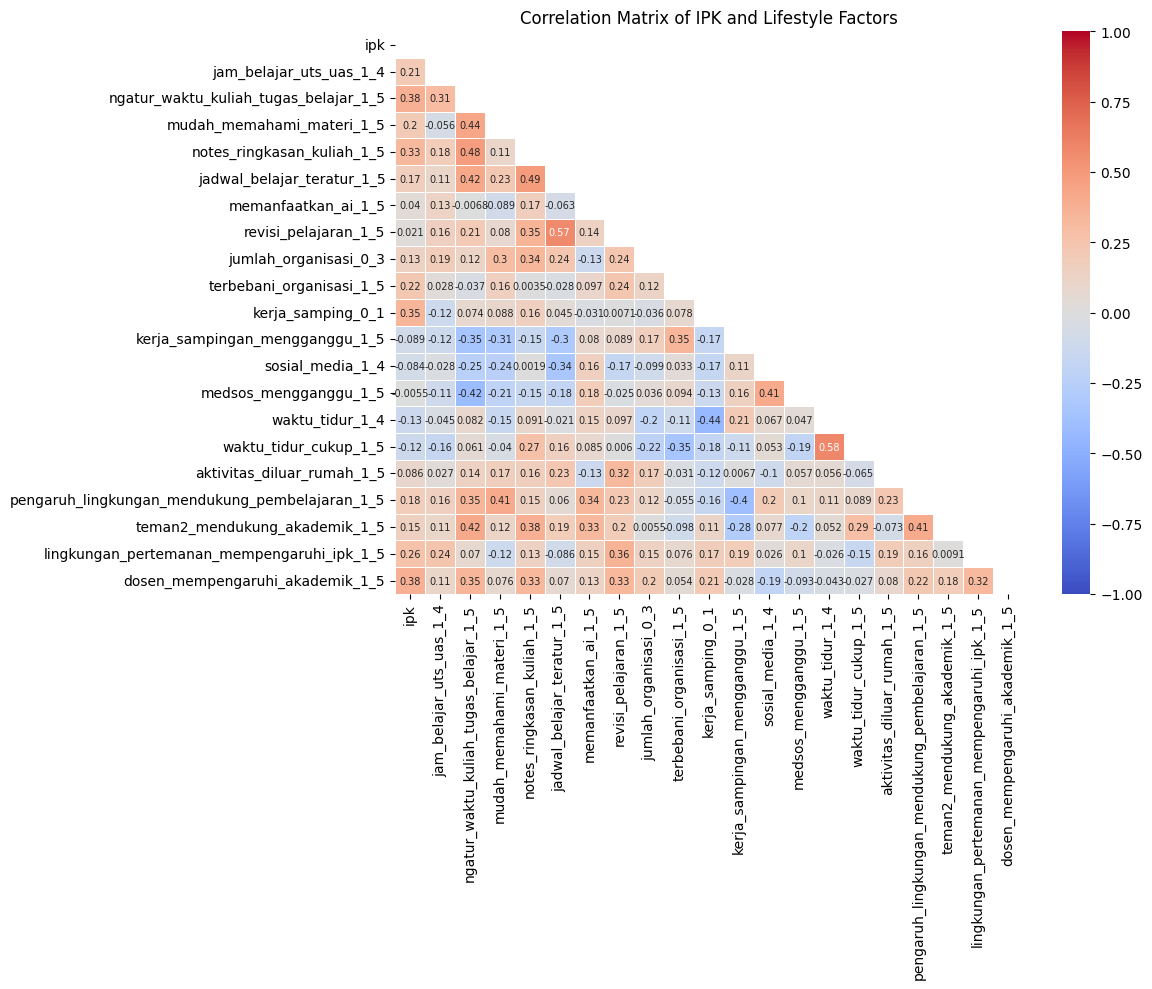

In [17]:
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, annot_kws={"size": 7},cmap='coolwarm', 
            vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of IPK and Lifestyle Factors')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')

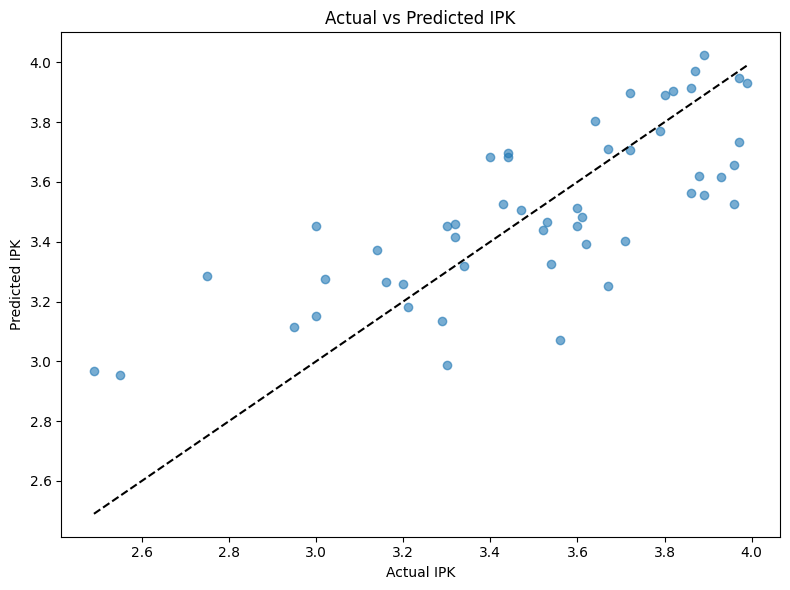

In [18]:
plt.figure(figsize=(8, 6))
predicted = model.predict()
plt.scatter(df['ipk'], predicted, alpha=0.6)
plt.plot([df['ipk'].min(), df['ipk'].max()], [df['ipk'].min(), df['ipk'].max()], 'k--')
plt.xlabel('Actual IPK')
plt.ylabel('Predicted IPK')
plt.title('Actual vs Predicted IPK')
plt.tight_layout()
plt.savefig('actual_vs_predicted.png')

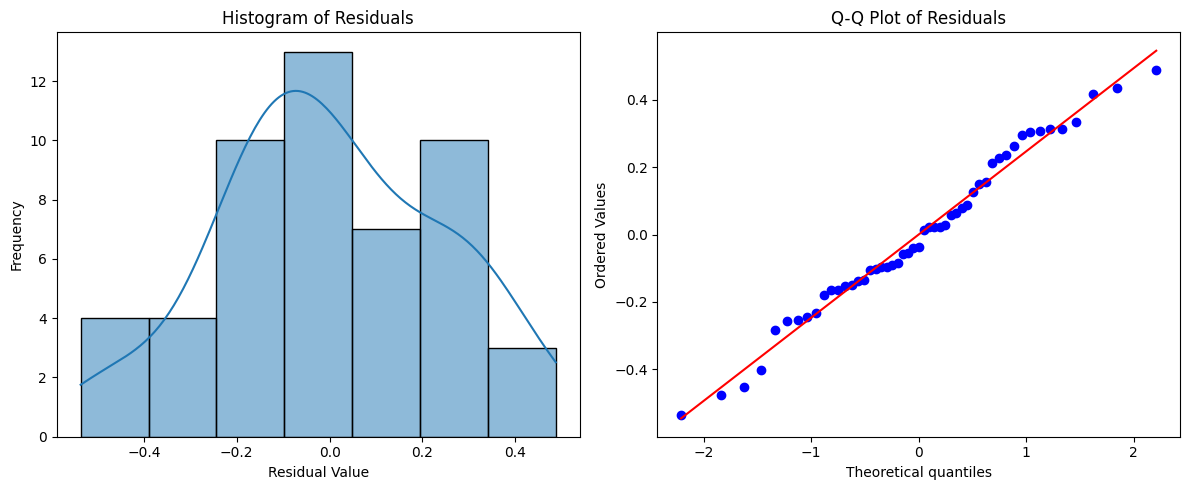

In [19]:
residuals = model.resid
plt.figure(figsize=(12, 5))

# Histogram of residuals
plt.subplot(121)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')

plt.subplot(122)
stats.probplot(residuals, plot=plt)
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.savefig('residual_analysis.png')